In [186]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from PIL import Image
from tqdm import tqdm
import os
import math


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error


def show(x_test,target,idx,model):
    a=np.expand_dims(x_test[target+idx], axis=0)
    prd=model.predict(a)
    aa=[]
    for b in prd[0][-1]:
        bb=[]
        for c in b:
            bb.append([c,c,c])
        aa.append(bb)
    aa=np.array(aa)[:,:,:,0]
    if idx==0:
        predict=np.expand_dims(aa,axis=0)
    else:
        predict = np.concatenate((predict, np.expand_dims(aa,axis=0)), axis=0)
def MAPE(y_test, y_pred,vervose=1):
    # print(y_test.shape, y_pred.shape)
    all=(zip(y_test,y_pred))
    
    cnt=0
    cost=0
    up=0
    down=0
    for t,p in all:#t로나눠
        if t==0:
            # c=np.abs(t-p) / p
            continue
        else:
            c=np.abs(t-p) / t
            cnt+=1
            cost+=c
            if c>0.5:
                if t> 40:
                    up+=1
                else:
                    down+=1
    if vervose==1:
        print(f"up: {up}  down : {down}")
    return cost/cnt*100


def compute_metrics(original,predict,start,end):
    start-=1
    end-=1
    y=original[:,start:end,:,:]
    y_pred=predict[:,start:end,:,:]
    
    # mape=MAPE(y.reshape(-1,),y_pred.reshape(-1,))
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()

    mape=MAPE(y_flatten,y_pred_flatten,0)

    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return np.array([mse,mape,mae])



def metrics_(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()


    mape=MAPE(y_flatten,y_pred_flatten)
    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return [mse,mape,mae]

def metrics_jam(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100
    # 속도 40이하만 필터링
    y_filtered=y[y <40]
    y_pred_filtered=y_pred[y < 40]

    
    mape=MAPE(y_filtered,y_pred_filtered)
    mse=mean_squared_error(y_filtered,y_pred_filtered)
    mae=mean_absolute_error(y_filtered,y_pred_filtered)
    return [mse,mape,mae]

def _predict(models,i, x_test ,target):
    for idx in range(7):
        a=np.expand_dims(x_test[target+idx], axis=0)

        prd=models[i].predict(a)
        #gray에서 이미지보여주려고 ch3만듬
        all=[]
        #예측된거 마지막꺼만 가져옴
        for img in prd[0][-1]:
            pixel=[]
            for gray in img:
                pixel.append([gray,gray,gray])
            all.append(pixel)
        all=np.array(all)[:,:,:,0]
    
        if idx==0:
            predict=np.expand_dims(all,axis=0)
            
        else:
            predict = np.concatenate((predict, np.expand_dims(all,axis=0)), axis=0)
    return predict



def make_predict(models, model_num, x_test ,target,original):
    predicts=[]
    for i in range(model_num):
    
        predict=_predict(models,i,x_test,target)

        print()
        print(f"{i}번째")
        print("속도 전체 에러율")
        mse,mape,mae=metrics_(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")
        print("속도 40이하 에러율")
        mse,mape,mae=metrics_jam(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")

        #모든 모델 확인하기 위해 리스트에 저장
        predicts.append(predict)
    return predicts


# test all 2020

In [184]:


path="D:/npz_gray_7_64_fix_inverse"

models=[]
# models.append(keras.models.load_model('my_model_test_100_binary_crossentropy_0.001.h5'))
# models.append(keras.models.load_model('my_model_mse_1026_gray_batch16_win7.h5'))
# my_model_mse_1103_gray_batch16_win7_fil16


# models.append(keras.models.load_model('fixversion_128_layer4_0.001_mse_inverse_0.1.h5'))
#이게 제일 잘됨
models.append(keras.models.load_model('fixversion_128_layer6_0.0001_mse_inverse_0.1.h5'))



# models.append(keras.models.load_model('fixversion_128_layer3_0.001_mse_inverse_drop0.1.h5'))
# models.append(keras.models.load_model('fixversion_128_layer6_0.0001_mse_inverse_0.1.h5'))





(64, 7, 24, 14, 1)
(7, 24, 14, 1)

0번째
속도 전체 에러율
up: 8  down : 223
rmse : 8.598374924307025 , mape : 15.966800630053015 , mae : 5.935738967007854
속도 40이하 에러율
up: 0  down : 221
rmse : 15.714778087783166 , mape : 70.96876340077036 , mae : 13.871971772119455


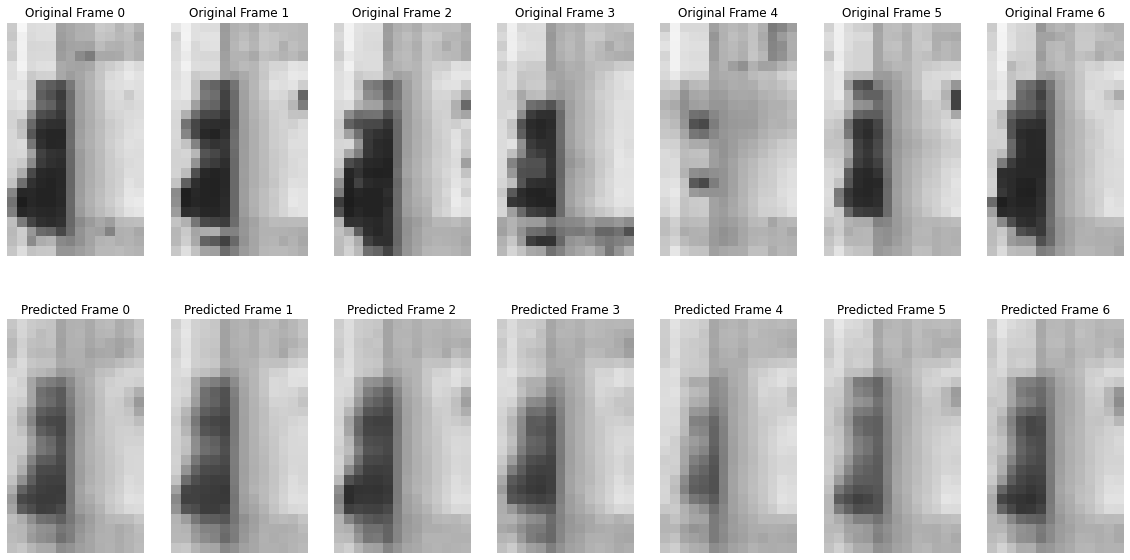

In [187]:
# 모든 모델 훈련시킨걸로 확인하기
x_test = np.load(f"{path}/batch/x/3.npz")['x']
print(x_test.shape)
target=0 # 
originals=[]
predicts=[]

model_num=1

#원본데이터
original=x_test[target+7]
print(original.shape)
all=[]
for img in original:
    # 
    # (a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)

fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    #inverse여서 1에서 빼준다
    ax.imshow(1-(original[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(1-predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")




0번째
속도 전체 에러율
up: 18  down : 145
rmse : 10.635891687111643 , mape : 15.068288518405994 , mae : 6.565274083679543
속도 40이하 에러율
up: 0  down : 144
rmse : 19.24044908464386 , mape : 70.66422056723674 , mae : 15.158504052799653


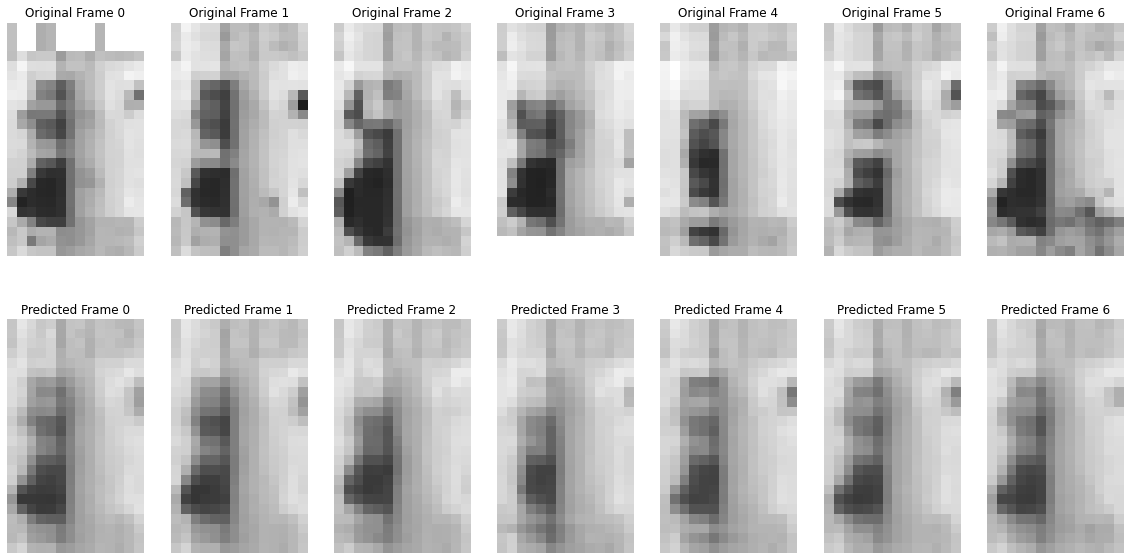

In [189]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/7.npz")['arr_0']
target=3 # 
originals=[]
predicts=[]
model_num=1

#원본데이터
original=x_test[target+6]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(1-original[idx])
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(1-predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")


In [193]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
for k in range(1):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/1.npz")['arr_0']
    for target in range(batch_size-win+1):

        predict=_predict(models,k,x_test,target)
        
        
        original=x_test[target+5]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        
        original=np.array(all)[:,:,:,:,0]
        
        #inverse니까 1에서 빼기
        original=1-original
        predict=1-predict

        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)

        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)


    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

In [194]:
#(모델갯수, (before,after,peak,rest), npz전체(batch-win) ,(mse,mape,mae))
total.shape

(1, 4, 58, 3)

In [195]:
total[0,:,9,1]

array([13.82257863, 19.5068612 , 30.73286737, 13.99766947])

In [196]:
# mse,mape,mae
for i in range(1):
    print(f"{i}번째")
    print("before")
    print(np.mean(total[i][0],axis=0))
    print("peak")
    print(np.mean(total[i][1],axis=0))
    print("after")
    print(np.mean(total[i][2],axis=0))
    print("rest")
    print(np.mean(total[i][3],axis=0))
    print("표준편차")
    print("before")
    print(np.std(total[i][0],axis=0))
    print("peak")
    print(np.std(total[i][1],axis=0))
    print("after")
    print(np.std(total[i][2],axis=0))
    print("rest")
    print(np.std(total[i][3],axis=0))

0번째
before
[141.93707921  15.14960738   8.10727476]
peak
[97.52356483 17.61070974  6.40173672]
after
[178.08492674  29.1372624    8.25527756]
rest
[64.59348627  8.74481059  4.92275383]
표준편차
before
[38.57466667  2.71457284  1.07880602]
peak
[20.11952351  2.46964453  0.51241582]
after
[17.02339223  3.05580526  0.69336412]
rest
[32.48994613  2.94998675  1.34136275]
